In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/jkrieger/work/ray_tracing/python')
import mantaray
import math

In [3]:
g = 9.8
def period2wavenumber(T):
    k = (2*np.pi)**2/g/T**2
    return k

def group_velocity(k):
    cg = 0.5*(g/k)**.5
    return cg

In [4]:
def haversine(coord1, coord2):
    '''
    This outputs the distance in meters between two lat/lon coordinates.
    '''
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

def along_track(data, start, end):
    '''
    This outputs the along track distance in meters between a series of lat/lon coordinates.
    '''
    sub_ds = data.sel(time=slice(start,end))
    R = 6372800  # Earth radius in meters
    distance = 0
    i=0

    for i in range(len(sub_ds.latitude)-1):
        lat1, lon1 = sub_ds.latitude[i], sub_ds.longitude[i]
        lat2, lon2 = sub_ds.latitude[i+1], sub_ds.longitude[i+1]
        phi1, phi2 = math.radians(lat1), math.radians(lat2)
        dphi       = math.radians(lat2 - lat1)
        dlambda    = math.radians(lon2 - lon1)
        a = math.sin(dphi/2)**2 + \
            math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
        distance += 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return distance

In [5]:
ww_2021 = xr.load_dataset('/Users/jkrieger/work/member-Krieger/saildrone_analysis/smode_data/WW3_SMODE_Pilot.nc')
pilot_1062 = xr.load_dataset('/Users/jkrieger/work/member-Krieger/saildrone_analysis/Saildrones/SMODE_Pilot_1062.nc')
pilot_1072 = xr.load_dataset('/Users/jkrieger/work/member-Krieger/saildrone_analysis/Saildrones/SMODE_Pilot_1072.nc')
pilot_1073 = xr.load_dataset('/Users/jkrieger/work/member-Krieger/saildrone_analysis/Saildrones/SMODE_Pilot_1073.nc')
pilot_1074 = xr.load_dataset('/Users/jkrieger/work/member-Krieger/saildrone_analysis/Saildrones/SMODE_Pilot_1074.nc')
pilot_1075 = xr.load_dataset('/Users/jkrieger/work/member-Krieger/saildrone_analysis/Saildrones/SMODE_Pilot_1075.nc')

In [6]:
start_date = '2021-10-30T11:00:00.000000000' # start date and time of front
end_date = '2021-10-30T22:00:00.000000000' # end date and time of front
ww_slice = ww_2021.sel(time=slice(start_date, end_date))
sub_1062 = pilot_1062.sel(time=slice(start_date, end_date))
sub_1072 = pilot_1072.sel(time=slice(start_date, end_date))
sub_1073 = pilot_1073.sel(time=slice(start_date, end_date))
sub_1074 = pilot_1074.sel(time=slice(start_date, end_date))
sub_1075 = pilot_1075.sel(time=slice(start_date, end_date))
non_masked_1062 = sub_1062['sea_surface_wave_significant_height'].where(~sub_1062['sea_surface_wave_significant_height'].isnull(), drop=True)
non_masked_1072 = sub_1072['sea_surface_wave_significant_height'].where(~sub_1072['sea_surface_wave_significant_height'].isnull(), drop=True)
non_masked_1073 = sub_1073['sea_surface_wave_significant_height'].where(~sub_1073['sea_surface_wave_significant_height'].isnull(), drop=True)
non_masked_1074 = sub_1074['sea_surface_wave_significant_height'].where(~sub_1074['sea_surface_wave_significant_height'].isnull(), drop=True)
non_masked_1075 = sub_1075['sea_surface_wave_significant_height'].where(~sub_1075['sea_surface_wave_significant_height'].isnull(), drop=True)

In [7]:
# Define model domain
# Length of domain in meters
Lx = haversine((ww_slice.latitude[0], ww_slice.longitude[0]), (ww_slice.latitude[0], ww_slice.longitude[-1]))
Ly = haversine((ww_slice.latitude[0], ww_slice.longitude[0]), (ww_slice.latitude[-1], ww_slice.longitude[0]))

# grid spacing
dx = haversine((ww_slice.latitude[0], ww_slice.longitude[0]), (ww_slice.latitude[0], ww_slice.longitude[1]))
dy = haversine((ww_slice.latitude[0], ww_slice.longitude[0]), (ww_slice.latitude[1], ww_slice.longitude[0]))

# hs vals
hs = ww_slice.hs[0,:,:].values

y = np.arange(0, Ly, dy)  # Ensures correct size
x = np.arange(0, Lx+(dx), dx)  # Ensures correct size

nx, ny = len(x), len(y)

u = ww_slice.ucur[0,:,:].values
v = ww_slice.vcur[0,:,:].values

In [8]:
# Convert Saildrone values into meter scale
first_sd_lat = sub_1062.latitude.values[0]
first_sd_lon = sub_1062.longitude.values[0]+360
first_lat_index = np.argmin(abs(ww_2021.latitude.values - first_sd_lat))
first_lon_index = np.argmin(abs(ww_2021.longitude.values - first_sd_lon))

'''
sd_y = []
sd_x = []
for i in range(len(sub_1062.latitude.values)):
    sd_lat = sub_1062.latitude.values[i]
    sd_lon = sub_1062.longitude.values[i]+360
    lat_index = np.argmin(abs(ww_2021.latitude.values - sd_lat))
    lon_index = np.argmin(abs(ww_2021.longitude.values - sd_lon))
    y = lat_index*dy
    x = lon_index*dx
    sd_y.append(y)
    sd_x.append(x)
'''

'\nsd_y = []\nsd_x = []\nfor i in range(len(sub_1062.latitude.values)):\n    sd_lat = sub_1062.latitude.values[i]\n    sd_lon = sub_1062.longitude.values[i]+360\n    lat_index = np.argmin(abs(ww_2021.latitude.values - sd_lat))\n    lon_index = np.argmin(abs(ww_2021.longitude.values - sd_lon))\n    y = lat_index*dy\n    x = lon_index*dx\n    sd_y.append(y)\n    sd_x.append(x)\n'

In [9]:
lon_mean = np.mean(ww_slice.longitude)
lat_mean = np.mean(ww_slice.latitude)

# Step 1
Lon_meter0 = ((ww_slice.longitude-np.mean(ww_slice.longitude))*1_852*60*np.cos(np.mean(ww_slice.latitude)*np.pi/180))
Lat_meter0 = ((ww_slice.latitude-np.mean(ww_slice.latitude))*1_852*60)

# Step 2
Lon_traj_meter = ((sub_1062.longitude - lon_mean) * 1_852 * 60 * np.cos(lat_mean * np.pi / 180)) + np.max(Lon_meter0)
Lat_traj_meter = ((sub_1062.latitude - lat_mean) * 1_852 * 60) + np.max(Lat_meter0)
Lon_traj_meter = np.flip(np.abs(Lon_traj_meter))

In [10]:
'''
ds = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "hs": (["y", "x"], hs, {"long_name": "hs", "units": "m"}),
        "u": (["y", "x"], u, {"long_name": "u", "units": "m/s"}),
        "v": (["y", "x"], v, {"long_name": "v", "units": "m/s"}),
    })
#ds.to_netcdf('m_scale_wavewatch_refraction_slice.nc', format="NETCDF3_CLASSIC")

# Considering a constant depth of 4km
D = 4e3 
depth = D*np.ones((ny, nx))

ds = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "depth": (["y", "x"], depth, {"long_name": "depth", "units": "m"}),
    })

#ds.to_netcdf('m_scale_refraction_bathy.nc', format="NETCDF3_CLASSIC")
'''
surface_1062 = sub_1062.sel(cell_depth=0, method='nearest')
ww_m = xr.load_dataset('data/currents/m_scale_wavewatch_refraction_slice.nc')
sd_ww_x_diff = np.abs(Lon_traj_meter[0]) - ww_m.x[first_lon_index]
Lon_traj_meter = Lon_traj_meter-sd_ww_x_diff

hs = sub_1062.sea_surface_wave_significant_height.values
u = surface_1062.eastward_sea_water_velocity.values
v = surface_1062.northward_sea_water_velocity.values
x = Lon_traj_meter.data
y = Lat_traj_meter.data

ds = xr.Dataset(
    data_vars={
        "x": (["time"], x),
        "y": (["time"], y),
        "u": (["time", "x"], u, {"long_name": "u", "units": "m/s"}),
    })

ValueError: Variable 'u': Could not convert tuple of form (dims, data[, attrs, encoding]): (['time', 'x'], array([ 0.25 ,  0.262,  0.259,  0.247,  0.239,  0.241,  0.266,  0.229,
        0.244,  0.272,  0.233,  0.251,  0.235,  0.204,  0.181,  0.165,
        0.132,  0.137,  0.139,  0.134,  0.166,  0.191,  0.196,  0.211,
        0.173,  0.139,  0.164,  0.158,  0.179,  0.181,  0.234,  0.25 ,
        0.271,  0.287,  0.277,  0.278,  0.28 ,  0.295,  0.298,  0.276,
        0.241,  0.253,  0.232,  0.241,  0.25 ,  0.245,  0.246,  0.239,
        0.213,  0.189,  0.218,  0.208,  0.165,  0.187,  0.168,  0.162,
        0.189,  0.193,  0.166,  0.18 ,  0.187,  0.193,  0.18 ,  0.198,
        0.194,  0.184,  0.225,  0.235,  0.239,  0.244,  0.239,  0.222,
        0.211,  0.238,  0.195,  0.19 ,  0.172,  0.148,  0.16 ,  0.191,
        0.172,  0.158,  0.136,  0.122,  0.133,  0.141,  0.139,  0.162,
        0.141,  0.174,  0.196,  0.179,  0.177,  0.189,  0.199,  0.21 ,
        0.158,  0.189,  0.182,  0.198,  0.183,  0.161,  0.195,  0.201,
        0.202,  0.193,  0.207,  0.195,  0.193,  0.22 ,  0.233,  0.226,
        0.241,  0.207,  0.203,  0.179,  0.168,  0.161,  0.133,  0.145,
        0.154,  0.164,  0.148,  0.143,  0.137,  0.126,  0.095,  0.057,
        0.002, -0.013,  0.014,  0.003,  0.04 ]), {'long_name': 'u', 'units': 'm/s'}) to Variable.

In [48]:
sub_1062

<xarray.Dataset> Size: 176kB
Dimensions:                              (time: 133, cell_depth: 50)
Coordinates:
  * time                                 (time) datetime64[ns] 1kB 2021-10-30...
  * cell_depth                           (cell_depth) float64 400B 3.9 ... 101.9
    latitude                             (time) float64 1kB 37.47 ... 37.43
    longitude                            (time) float64 1kB -124.4 ... -124.0
Data variables: (12/15)
    upward_sea_water_velocity            (time, cell_depth) float64 53kB 0.0 ...
    northward_sea_water_velocity         (time, cell_depth) float64 53kB -0.3...
    eastward_sea_water_velocity          (time, cell_depth) float64 53kB 0.25...
    eastward_wind                        (time) float64 1kB 5.14 4.9 ... 5.25
    eastward_wind_stddev                 (time) float64 1kB 0.25 0.25 ... 0.46
    northward_wind                       (time) float64 1kB 0.69 0.99 ... 1.9
    ...                                   ...
    sea_surface_wave_significant_period  (time) float64 1kB 11.64 nan ... 11.64
    sea_surface_wave_significant_height  (time) float64 1kB 1.504 nan ... 2.035
    surface_temperature                  (time) float64 1kB 15.57 ... 14.27
    surface_temperature_stddev           (time) float64 1kB 0.0004 ... 0.0021
    sea_surface_salinity                 (time) float64 1kB 32.55 ... 32.63
    sea_surface_salinity_stddev          (time) float64 1kB 0.0002 ... 0.0003
Attributes: (12/14)
    title:                S-MODE Pilot Campaign Fall 2021 Temperature, Salini...
    summary:              5 min surface metereological and oceanographic data...
    conventions:          cf
    netcdf_version:       4.6.3
    creator_name:         ['Caesar B. Rocha', 'Senya Stein']
    creator_email:        senyarocks11@gmail.com
    ...                   ...
    time_coverage_end:    2021-11-07T23:50:00.000000000
    project:              Sub-Mesoscale Ocean Dynamics Experiment (S-MODE)
    longitude_min:        -125.31330104917288
    longitude_max:        -123.17863076459616
    latitude_min:         37.10557549260557
    latitude_max:         37.86236185580492

In [50]:
print(x.shape)
print(u.shape)
print(y.shape)

(133,)
(133,)
(133,)


In [52]:
ds = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "u": (["y", "x"], u, {"long_name": "u", "units": "m/s"}),
    })

ValueError: Variable 'u': Could not convert tuple of form (dims, data[, attrs, encoding]): (['y', 'x'], array([ 0.25 ,  0.262,  0.259,  0.247,  0.239,  0.241,  0.266,  0.229,
        0.244,  0.272,  0.233,  0.251,  0.235,  0.204,  0.181,  0.165,
        0.132,  0.137,  0.139,  0.134,  0.166,  0.191,  0.196,  0.211,
        0.173,  0.139,  0.164,  0.158,  0.179,  0.181,  0.234,  0.25 ,
        0.271,  0.287,  0.277,  0.278,  0.28 ,  0.295,  0.298,  0.276,
        0.241,  0.253,  0.232,  0.241,  0.25 ,  0.245,  0.246,  0.239,
        0.213,  0.189,  0.218,  0.208,  0.165,  0.187,  0.168,  0.162,
        0.189,  0.193,  0.166,  0.18 ,  0.187,  0.193,  0.18 ,  0.198,
        0.194,  0.184,  0.225,  0.235,  0.239,  0.244,  0.239,  0.222,
        0.211,  0.238,  0.195,  0.19 ,  0.172,  0.148,  0.16 ,  0.191,
        0.172,  0.158,  0.136,  0.122,  0.133,  0.141,  0.139,  0.162,
        0.141,  0.174,  0.196,  0.179,  0.177,  0.189,  0.199,  0.21 ,
        0.158,  0.189,  0.182,  0.198,  0.183,  0.161,  0.195,  0.201,
        0.202,  0.193,  0.207,  0.195,  0.193,  0.22 ,  0.233,  0.226,
        0.241,  0.207,  0.203,  0.179,  0.168,  0.161,  0.133,  0.145,
        0.154,  0.164,  0.148,  0.143,  0.137,  0.126,  0.095,  0.057,
        0.002, -0.013,  0.014,  0.003,  0.04 ]), {'long_name': 'u', 'units': 'm/s'}) to Variable.

# Initialize wave parameters

In [11]:
# Period of incident waves in seconds
T0 = 11

# Direction of incident waves in radians (trig convention, going to)
theta_deg = 306.4
theta0 = np.deg2rad(theta_deg)

# Convert period to wavenumber magnitude
k0 = period2wavenumber(T0)

# Calculate wavenumber components
kx0 = k0*np.cos(theta0)
ky0 = k0*np.sin(theta0)

# Number of rays
n_rays = 100

# Initialize wavenumber for all rays
Kx0 = kx0*np.ones(n_rays)
Ky0 = ky0*np.ones(n_rays)

# Current and bathymetry file path
m_scale_bathy = 'data/bathymetry/m_scale_refraction_bathy.nc'
m_scale = 'data/currents/m_scale_wavewatch_refraction_slice.nc'

ds = xr.open_dataset(m_scale)

x = ds.x.values
y = ds.y.values

# Creates initial x position for all rays
x0 = np.linspace(5, 400000, num=n_rays)  
y0 = np.full_like(x0, 400000)

# Estimates CFL
# Computes grid smallest spacing
dd = np.min([np.diff(x).mean(), np.diff(y).mean()])

# Computes group velocity
cg = group_velocity(k0)

# Computes CFL
cfl = dd/cg

duration = round(x.max()/cg)
step_size = cfl

# Initialize ray tracing and ray positions

In [12]:
bundle = mantaray.ray_tracing(x0, y0, Kx0, Ky0, duration, step_size, m_scale_bathy, m_scale)

Text(0.5, 1.0, 'WAVEWATCH III currents with ray tracing')

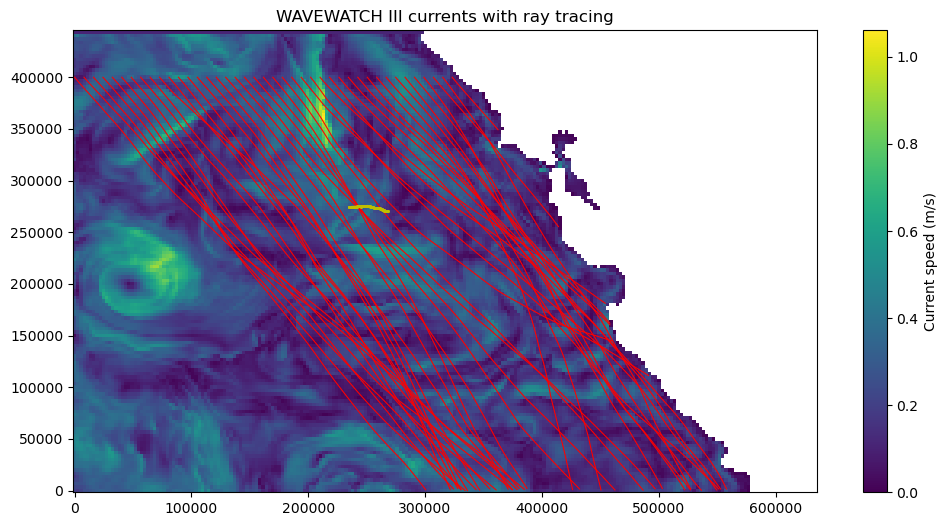

In [13]:
X = ds.x
Y = ds.y
U = (ds.u**2 + ds.v**2)**.5
sd_ww_x_diff = np.abs(Lon_traj_meter[0]) - ds.x[first_lon_index]

plt.figure(figsize=(12, 6))
cs = plt.pcolormesh(X, Y, U)
for i in range(bundle.ray.size)[::2]:
    ray = bundle.isel(ray=i)
    plt.plot(ray.x, ray.y, 'red', lw=.78)
plt.plot(Lon_traj_meter, Lat_traj_meter, marker='o', c='y', ms=1, label='Saildrone 1062 data')
plt.colorbar(cs, label='Current speed (m/s)')
#plt.legend(loc='upper right')
plt.title('WAVEWATCH III currents with ray tracing')

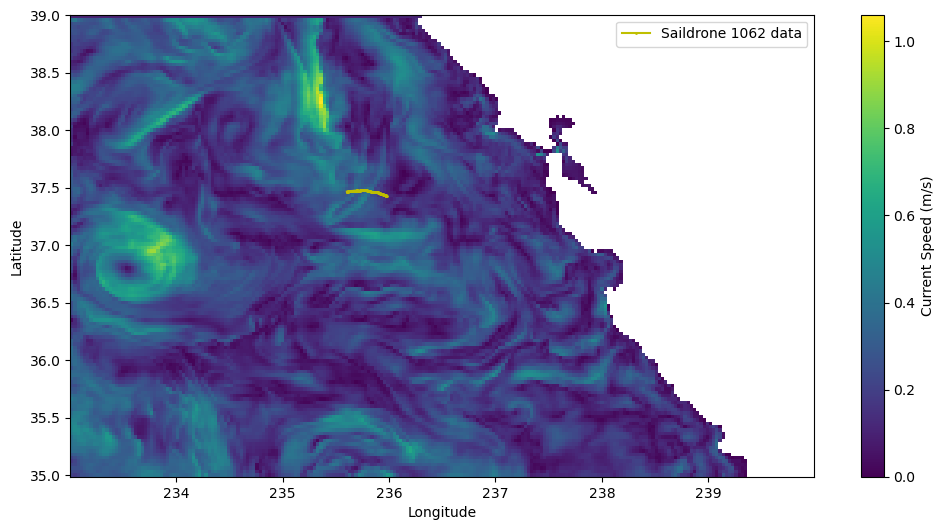

In [14]:
cur_values = ((ww_slice.ucur[0,:,:])**2 + (ww_slice.vcur[0,:,:])**2)**0.5
plt.figure(figsize=(12, 6))
plt.pcolormesh(ww_slice.longitude, ww_slice.latitude, cur_values)
plt.plot(sub_1062.longitude+360, sub_1062.latitude, marker='o', c='y', ms=1, label='Saildrone 1062 data')
plt.colorbar(label='Current Speed (m/s)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right')
plt.show()

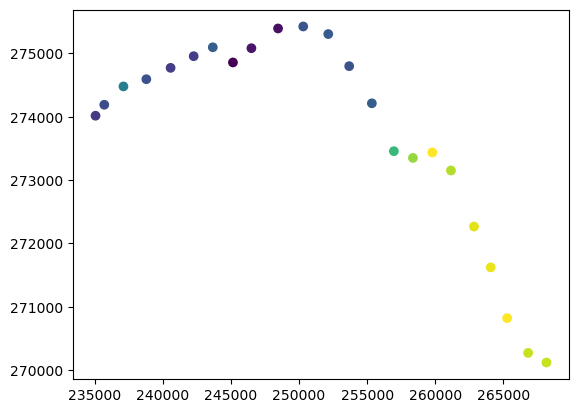

In [15]:
plt.scatter(Lon_traj_meter[::6], Lat_traj_meter[::6], c=non_masked_1062)

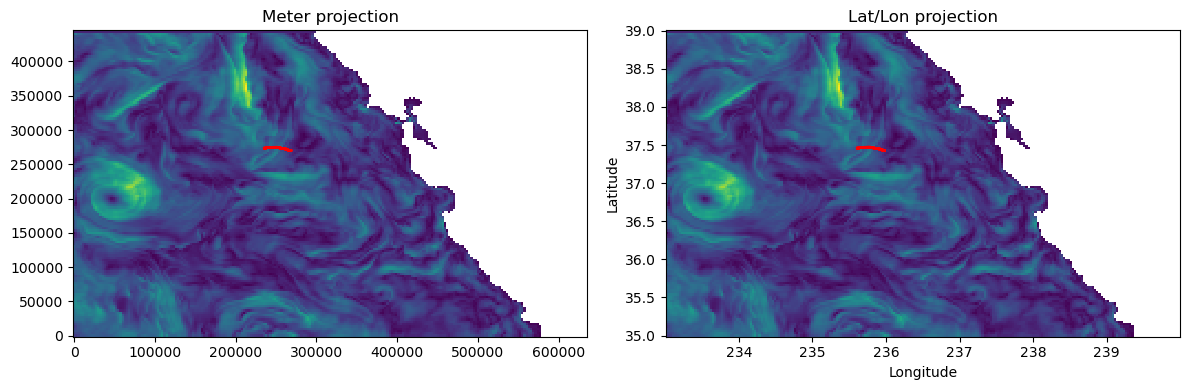

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cs = axes[0].pcolormesh(X, Y, U)
axes[0].plot(Lon_traj_meter - sd_ww_x_diff, Lat_traj_meter, marker='o', c='r', ms=1)
axes[0].set_title('Meter projection')
cs2 = axes[1].pcolormesh(ww_slice.longitude, ww_slice.latitude, cur_values)
axes[1].plot(sub_1062.longitude + 360, sub_1062.latitude, marker='o', c='r', ms=1)
axes[1].set_title('Lat/Lon projection')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'WAVEWATCH III H_s with ray tracing')

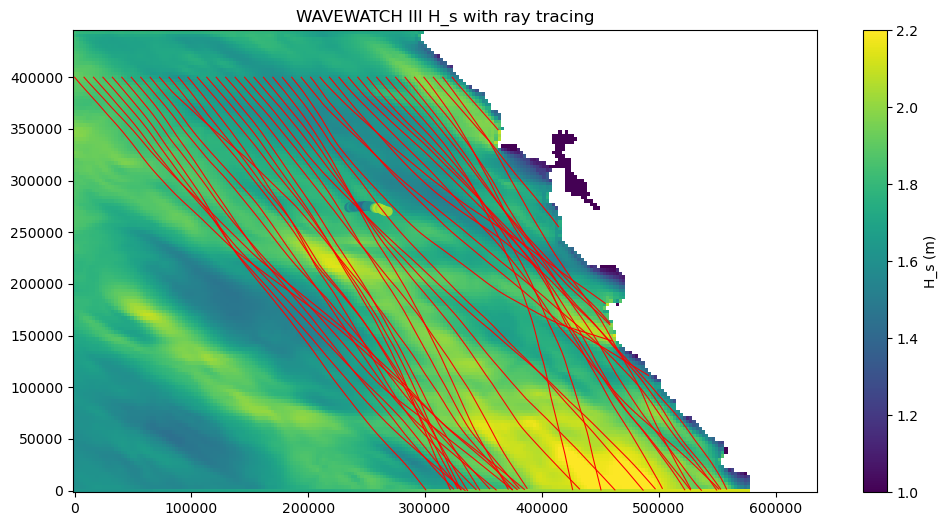

In [20]:
X = ds.x
Y = ds.y
U = (ds.u**2 + ds.v**2)**.5
hs = ds.hs
plt.figure(figsize=(12, 6))
cs = plt.pcolormesh(X, Y, hs, vmin=1, vmax=2.2)
for i in range(bundle.ray.size)[::2]:
    ray = bundle.isel(ray=i)
    plt.plot(ray.x, ray.y, 'red', lw=.78)
#plt.plot(Lon_traj_meter-sd_ww_x_diff, Lat_traj_meter, marker='o', c='b', ms=1)
plt.scatter(Lon_traj_meter[::6], Lat_traj_meter[::6], c=non_masked_1062, vmin=1, vmax=2.2)
#plt.legend(loc='upper right')
plt.colorbar(cs, label='H_s (m)')
plt.title('WAVEWATCH III H_s with ray tracing')